In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

from diffdrr.drr import DRR
from diffdrr.data import load_example_ct
from diffdrr.metrics import XCorr2
from diffdrr.visualization import plot_drr

np.random.seed(39)

In [ ]:
def converged(df):
    return df["loss"].iloc[-1] <= -0.999

In [ ]:
#|cuda
defaults = ("cuda" if torch.cuda.is_available() else "cpu", torch.float32)
print(defaults)

('cuda', torch.float32)


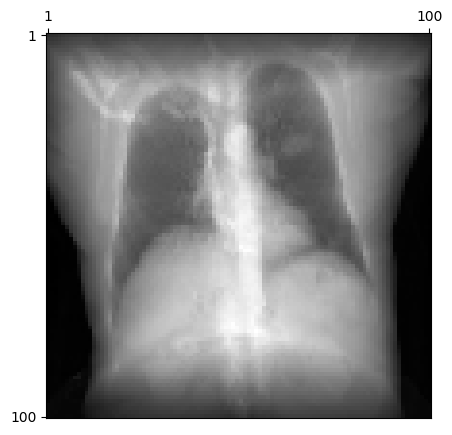

In [ ]:
#|cuda
# Make the ground truth X-ray
SDR = 300.0
HEIGHT = 100
DELX = 8.0

volume, spacing = load_example_ct()
bx, by, bz = np.array(volume.shape) * np.array(spacing) / 2
true_params = {
    "sdr": SDR,
    "theta": torch.pi,
    "phi": 0,
    "gamma": torch.pi / 2,
    "bx": bx,
    "by": by,
    "bz": bz,
}

drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(*defaults)
rotations = torch.tensor([[true_params["theta"], true_params["phi"], true_params["gamma"]]])
translations = torch.tensor([[true_params["bx"], true_params["by"], true_params["bz"]]])

drr.move_carm(rotations, translations)
ground_truth = drr()

plot_drr(ground_truth)
plt.show()

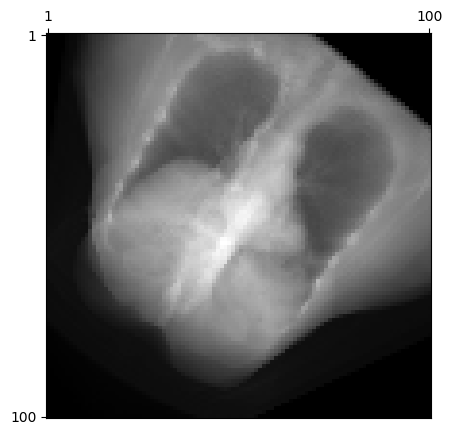

In [ ]:
#|cuda
# Make a random DRR
def get_initial_parameters(true_params):
    theta = true_params["theta"] + np.random.uniform(-np.pi / 4, np.pi / 4)
    phi = true_params["phi"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    gamma = true_params["gamma"] + np.random.uniform(-np.pi / 3, np.pi / 3)
    bx = true_params["bx"] + np.random.uniform(-30.0, 31.0)
    by = true_params["by"] + np.random.uniform(-30.0, 31.0)
    bz = true_params["bz"] + np.random.uniform(-30.0, 31.0)
    return torch.tensor([[theta, phi, gamma]]), torch.tensor([[bx, by, bz]])


rotations, translations = get_initial_parameters(true_params)
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX)
drr.move_carm(rotations, translations)
est = drr().detach()

plot_drr(est)
plt.show()

In [ ]:
def optimize(
    drr,
    ground_truth,
    lr_rotations=5.3e-2,
    lr_translations=7.5e1,
    momentum=0,
    dampening=0,
    n_itrs=250
):
    criterion = XCorr2(zero_mean_normalized=True)
    optimizer = torch.optim.SGD(
        [
            {"params": [drr.rotations], "lr": lr_rotations},
            {"params": [drr.translations], "lr": lr_translations},
        ],
        momentum=momentum,
        dampening=dampening,
    )
    
    params = []
    for itr in tqdm(range(n_itrs)):
        # Save the current set of parameters
        theta, phi, gamma = drr.rotations.squeeze().tolist()
        bx, by, bz = drr.translations.squeeze().tolist()
        params.append([i for i in [theta, phi, gamma, bx, by, bz]])

        # Run the optimization loop
        optimizer.zero_grad()
        estimate = drr()
        loss = -criterion(ground_truth, estimate)
        loss.backward(retain_graph=True)
        optimizer.step()
        
        if loss < -0.999:
            tqdm.write(f"Converged in {itr} iterations")
            break
        
    return pd.DataFrame(params, columns=["theta", "phi", "gamma", "bx", "by", "bz"])

In [ ]:
#|cuda
# Base SGD
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(*defaults)
drr.move_carm(rotations, translations)
params_base = optimize(drr, ground_truth)
del drr

# SGD + momentum
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(*defaults)
drr.move_carm(rotations, translations)
params_momentum = optimize(drr, ground_truth, momentum=0.9)
del drr

# SGD + momentum + dampening
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(*defaults)
drr.move_carm(rotations, translations)
params_momentum_dampen = optimize(drr, ground_truth, momentum=0.9, dampening=0.1)
del drr

 55%|█████████████████████████████████████████▉                                  | 138/250 [00:03<00:03, 35.27it/s]


Converged in 138 iterations


 25%|███████████████████                                                          | 62/250 [00:01<00:05, 35.07it/s]


Converged in 62 iterations


 23%|█████████████████▊                                                           | 58/250 [00:01<00:05, 34.86it/s]

Converged in 58 iterations


In [ ]:
from IPython.display import display, HTML
from base64 import b64encode

from diffdrr.visualization import animate

In [ ]:
def animate_in_browser(df):
    out = animate("<bytes>", df, drr, ground_truth, verbose=True, extension=".webp", duration=30)
    display(HTML(f"""<img src='{"data:img/gif;base64," + b64encode(out).decode()}'>"""))

In [ ]:
#|cuda
drr = DRR(volume, spacing, sdr=SDR, height=HEIGHT, delx=DELX).to(*defaults)

In [ ]:
#|cuda
animate_in_browser(params_base)

Precomputing DRRs: 100%|█████████████████████████████████████████████████████████| 139/139 [00:25<00:00,  5.53it/s]


In [ ]:
#|cuda
animate_in_browser(params_momentum)

Precomputing DRRs: 100%|███████████████████████████████████████████████████████████| 63/63 [00:11<00:00,  5.37it/s]


In [ ]:
#|cuda
animate_in_browser(params_momentum_dampen)

Precomputing DRRs: 100%|███████████████████████████████████████████████████████████| 59/59 [00:10<00:00,  5.55it/s]
